<a href="https://colab.research.google.com/github/amr-hussain/OpenSourceAi/blob/main/UsingMobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import json

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.preprocessing import image_dataset_from_directory
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


In [ ]:
import kagglehub
import shutil

# Specify the desired download path
desired_path = '/content/asl-alphabet'  # Change to your preferred path

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)


# Source file path
source_path = path  # Replace with your source file path

# Destination file path
destination_path = '/content'  # Replace with your destination path

# Move the file
shutil.move(source_path, destination_path)

100%|██████████| 1.03G/1.03G [00:10<00:00, 101MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


'/content/1'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:

images_dir = '1/asl_alphabet_train/asl_alphabet_train'


### loading the dataset

In [ ]:
BATCH_SIZE = 128
IMG_SIZE =(224, 224)
train_dataset = image_dataset_from_directory(images_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(images_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)




Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [ ]:
print(len(train_dataset))

544


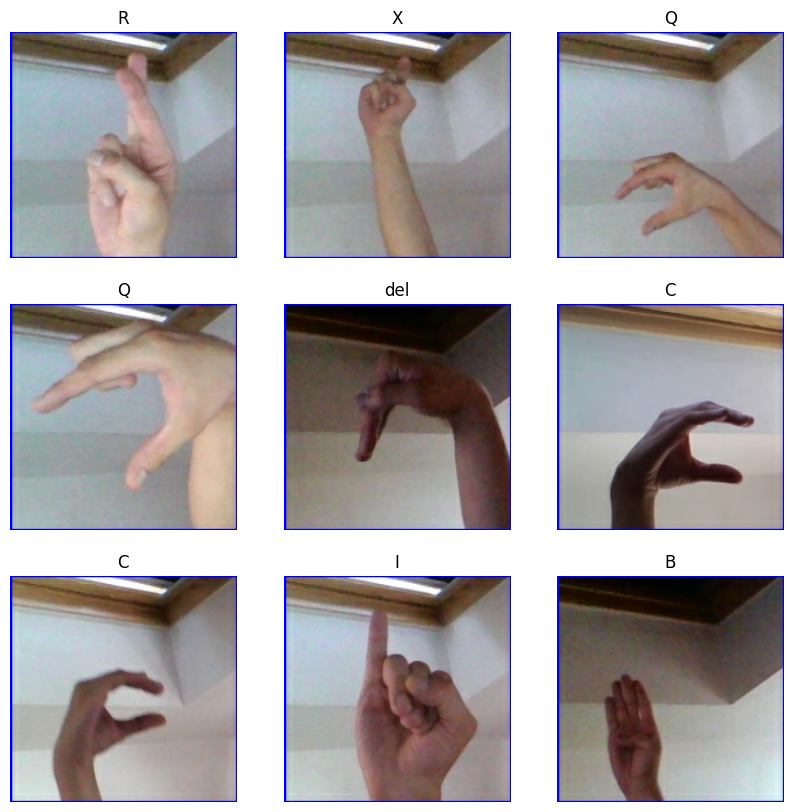

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
image_shape = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_shape,
    include_top=True,  # Set True to include the final fully-connected layer for classification
    weights='imagenet'  # Load pretrained ImageNet weights
)


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def customNet(image_shape = (224, 224), data_augmentation=None):
    input_shape  = image_shape + (3, )
    base_model = tf.keras.applications.MobileNetV2(input_shape= input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet')

    input_shape = image_shape + (3,)

    base_model.trainable = False

    inputs = tf.keras.Input(shape = input_shape)
    ## here i disabled the dataaugmentation step I have thousands of images
#     x = data_augmentation(inputs)
    # preprocessing the input to be standardized to the range the original model was trained on
    x = preprocess_input(inputs)
    # this is important to force some layers like dropout into inference mode
    x = base_model(x, training=False)
    # adding global~~~ to summerize the result of each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)

    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(29, activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model


In [ ]:
#nepocs = 3
my_model = customNet()
base_learning_rate = 0.001

my_model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
my_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 29)                  │          37,149 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,295,133 (8.76 MB)

 Trainable params: 37,149 (145.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

history = my_model.fit(train_dataset, validation_data=validation_dataset, epochs=3)

Epoch 1/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 140s 225ms/step - accuracy: 0.6933 - loss: 1.2360 - val_accuracy: 0.9748 - val_loss: 0.1676
Epoch 2/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 94s 161ms/step - accuracy: 0.9639 - loss: 0.1771 - val_accuracy: 0.9881 - val_loss: 0.0875
Epoch 3/3
  1/544 ━━━━━━━━━━━━━━━━━━━━ 8:11:22 54s/step - accuracy: 0.9688 - loss: 0.1467

In [ ]:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

## **saving the model locally for later reuse**

In [ ]:
my_model.save("MobileNetWithASL.h5")

#The rest of the notebook focuses on fine-tuning MobileNet to improve classification performance, but this step is unnecessary as the model already fits the data well, given the large size of the training set.

## fine tuning the model for better results
##### first you need to understand that the my_model was instantiated when the function custommodel was called so any compilation of the model will use the base_model global variable despite it was overritten inside the function when modifying it outside the function the compilation of my_model will use the latest edit.

In [ ]:
# base_model.trainable = True
# print(len(base_model.layers))
# ## outputs 156
# freeze_until = 134
# for l in base_model.layers[:134]:
#     l.trainable = False

# my_model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate * 0.1),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

In [ ]:
# fine_tune_epochs = 5
# total_epochs =  5 + fine_tune_epochs

# history2 = my_model.fit(train_dataset,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          validation_data=validation_dataset)


In [ ]:

# acc = [0.] + history2.history['accuracy']
# val_acc = [0.] + history2.history['val_accuracy']

# loss = history2.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 4))
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# # plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')
# plt.show()



In [ ]:
# test_dir = "testData"
# test_dataset = image_dataset_from_directory(test_dir,
#                                              image_size=(224, 224),
#                                              seed=0)
# def normalize(images, label):
#     return preprocess_input(images), label
# test_dataset = test_dataset.map(normalize)


In [ ]:
# import copy

In [ ]:
# v = copy.copy(validation_dataset)
# probabilities = my_model.predict(v)

# # Convert probabilities to binary predictions (0 or 1)
# predictions = np.where(probabilities > 0.5, 1, 0)


# true_labels = []
# # Step 1: Extract true labels
# for images, labels in v:
#     true_labels.append(labels.numpy())  # Collect true labels

# # Convert the list of arrays to a single NumPy array
# true_labels = np.concatenate(true_labels)
# tcount = 0
# for i in range(len(true_labels)) :
#     print(f"t:{true_labels[i]}, p:{predictions[i][0]}")
#     if true_labels[i] == predictions[i][0] : tcount += 1
# else :
#     print(f"total accuracy = {tcount/len(true_labels)}")
# my_model.evaluate(validation_dataset)

In [ ]:
# # class_names = test_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in test_dataset.take(1):
#     for i in range(3):
#         ax = plt.subplot(3, 3, i + 1)
#         image = images[i].numpy()
#         image = (image * 127.5) + 127.5
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.axis("off")

In [ ]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # Load an image
# image_path = 'cup.jpeg'#test_dir + '/amr.jpeg'  # Replace with your image path


# image = load_img(image_path, target_size=(224, 224))  # Resize to MobileNet input size



# image = img_to_array(image)  # Convert to NumPy array
# plt.imshow(image.astype("uint8"))
# # Expand dimensions to match the input shape of MobileNet
# image = tf.expand_dims(image, axis=0)

# # Preprocess the image
# image = preprocess_input(image)